# Download and Load GloVe Vectors

In [0]:
!pip install paramiko
!wget http://nlp.stanford.edu/data/glove.6B.zip
  
import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

from gensim.scripts.glove2word2vec import glove2word2vec
_ = glove2word2vec("glove.6B.300d.txt", "w2v_from_glove.6B.300d.txt")

from gensim.models import KeyedVectors
glove_embeddings = KeyedVectors.load_word2vec_format('w2v_from_glove.6B.300d.txt', binary=False)

    100% |████████████████████████████████| 194kB 23.0MB/s 
    100% |████████████████████████████████| 61kB 24.6MB/s 
    100% |████████████████████████████████| 2.3MB 10.1MB/s 
    100% |████████████████████████████████| 768kB 16.7MB/s 
    100% |████████████████████████████████| 102kB 31.2MB/s 
--2019-04-25 20:45:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-04-25 20:45:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.27MB/s    in 5m 22s  

2019-04-25 20:50:46 (2.55

# Actual Code

## Load data and pre-process

In [0]:
# Load Data
import numpy as np
import pandas as pd
import re
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
import spacy
tagger = spacy.load('en')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

data = pd.read_csv("demographicsSDD-1_fixed.csv")
data["Combined"] = data["Label"]
data = data.replace({'Combined': "HH"}, {'Combined': 'Household'}, regex=True)
data = data.replace({'Combined': "#"}, {'Combined': 'number'}, regex=True)
data = data.replace({'Combined': r"[^a-zA-Z]+"}, {'Combined': ' '}, regex=True)
data = data.replace({'attributeOf': '\?\?*'}, {'attributeOf': ''}, regex=True)
data = data.replace({'attributeOf': 'hh'}, {'attributeOf': 'Household'}, regex=True)
data = data[["Combined", "attributeOf", "Attribute"]].dropna()

data = data[data.Attribute != 'ncit:C114854']
data = data[data.Attribute != 'chear:UnknownAttribute']
labels = data.Attribute

from collections import Counter
label_stats = Counter(labels)

sentences = list(data.Combined.str.lower())


new_sentences = [] ; new_labels = [] ; weights = []
for i, lab in enumerate(labels):
  tags = tagger(sentences[i])
  temp = [token.text for token in tags if (token.dep_ in 'ROOT pobj nsubj compound') and len(token.text)>1]
  word_count = len(temp)
  temp = " ".join(temp)
  if len(temp)>0:
    temp_lab = " ".join([x for x in re.sub('(?<=[A-Za-z])(?=[A-Z][a-z])', ' ', lab.split(":")[1]).lower().split()])
    new_sentences.append(temp)
    new_labels.append(temp_lab)
    weights.append([word_count if token.dep_ == "ROOT" else 1 for token in tags if (token.dep_ in 'ROOT pobj nsubj compound') and len(token.text)>1])

    
print("Label frequencies in dataset : ", label_stats)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Label frequencies in dataset :  Counter({'sio:Quantity': 5, 'sio:Age': 4, 'chear:Language': 4, 'chear:EducationLevel': 4, 'sio:TimeInterval': 3, 'sio:StatusDescriptor': 3, 'sio:Race': 2, 'sio:Country': 2, 'sio:BiologicalSex': 2, 'chear:Weight': 2, 'chear:MaritalStatus': 2, 'chear:Income': 2, 'sio:Ratio': 1, 'sio:Identifier': 1})


## Convert data format to fit model input format

In [0]:
sentences = pd.Series(new_sentences)
labels = pd.Series(new_labels)

# Create list of all words in dataset
all_words = set()
sentences.str.split().apply(all_words.update)
labels.str.split().apply(all_words.update)
all_words = set([word for word in all_words if word in glove_embeddings and len(word)>1])

import re
word_list = set([x for x in all_words if len(x)>1])
token_dict = {x[1]:x[0] for x in enumerate(word_list)}

In [0]:
# Functions for Preprocessing Data

def convert_inputFormat(sentences, labels, labels_set, tokenizer, max_length_Sentence, max_length_label):
  from keras.preprocessing.sequence import pad_sequences
  from keras.utils import to_categorical
  
  return_data = {"X_sentences" : [], "X_labels" : [], "y" : []}
  for i in range(len(sentences)):
    for curr_label in labels_set:
      return_data["X_sentences"].append(sentences[i])
      return_data["X_labels"].append(curr_label)
      return_data["y"].append(1 if curr_label == labels[i] else 0)

  X_sentences = tokenizer.texts_to_sequences(return_data["X_sentences"])
  
  X_labels = tokenizer.texts_to_sequences(return_data["X_labels"])
  
  y = return_data["y"]
  
  return X_sentences, X_labels, y


In [ ]:
# Create data splits
from keras.preprocessing.text import Tokenizer

sentences = list(sentences)
labels = list(labels)
labels_set = list(set(labels))
max_length_Sentence = max([len(s.split()) for s in sentences])
max_length_label = max([len(s.split('_')) for s in set(labels)])

tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n0123456789', lower=True, oov_token=False)
tokenizer.fit_on_texts(labels+sentences)

from sklearn.model_selection import train_test_split
sentences_train = sentences
labels_train = labels

X_train_sent, X_train_labels, y_train = convert_inputFormat(sentences_train, labels_train, labels_set, tokenizer, max_length_Sentence, max_length_label)
weights_new=[]
for w in weights:
  weights_new.extend([w]*len(labels_set))
weights = weights_new

## Create embedding matrix

In [0]:
mu, sigma = 0.1, 0.4 # mean and standard deviation
embedding_size = 300

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_size))
for word, index in tokenizer.word_index.items():
  if word in glove_embeddings:
    embedding_matrix[index] = glove_embeddings[word]*(10**2)
  else:
    print("word not found: ", word)

word not found:  False
word not found:  acasi


## Model : Get distances

In [ ]:
from scipy import spatial
import math
similarity = []
  
  
## Using Distance measures
for sent, label, weight in zip(X_train_sent, X_train_labels, weights):
  sent_embd = embedding_matrix[sent]
  label_embd = embedding_matrix[label]
  result = [] ; wt = []
  for i, sent_word in enumerate(sent_embd):
    for label_word in label_embd:
      temp = spatial.distance.cosine(label_word, sent_word)
      if math.isnan(temp):
        continue
      elif temp == 0:
        result.append(4)
      else:
        result.append((1-temp))
      wt.append(weight[i])
  # Eucledian distance
  result = spatial.distance.euclidean(result, np.zeros(len(result)), w=wt)
  similarity.append(result)

## Change prediction format to calculate performance metrics

In [0]:
similarity = np.array(similarity)
similarity_sample = np.split(similarity, similarity.shape[0]/len(labels_set))
similarity_sample_normalized = np.array([((sample-sample.min())/(sample.max()-sample.min())) for sample in similarity_sample])

y_train = np.array(y_train)
y_train_sample = np.split(y_train, y_train.shape[0]/len(labels_set))

## Get performance scores

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(y_train_sample, axis=1), np.argmax(similarity_sample_normalized, axis=1))

0.7027027027027027

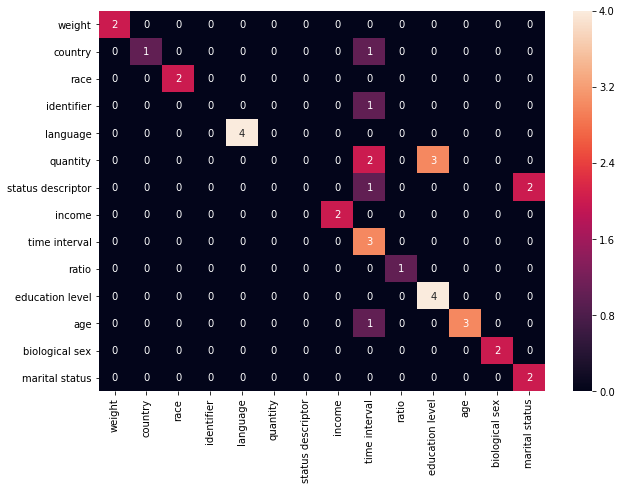

In [0]:
y_true_conf = [] ; y_pred_conf = []
for x in list(zip(np.argmax(y_train_sample, axis=1), np.argmax(similarity_sample_normalized, axis=1), sentences_train)):
  y_true_conf.append(label_dict[x[0]])
  y_pred_conf.append(label_dict[x[1]])

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_true_conf, y_pred_conf, labels=labels_set)
df_cm = pd.DataFrame(array, index = labels_set,
                  columns = labels_set)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)